In [ ]:
import numpy as np
import pandas as pd
import math
import numba, socket, time
import cudf
import dask, dask_cudf
import xgboost as xgb
import cuspatial
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster


# connect to the Dask cluster created at Dataproc startup time
cluster = LocalCUDACluster()
client = Client(cluster)
# forces workers to restart. useful to ensure GPU memory is clear
client.restart()

# # limit work-stealing as much as possible
# dask.config.set({'distributed.scheduler.work-stealing': False})
# dask.config.get('distributed.scheduler.work-stealing')
# dask.config.set({'distributed.scheduler.bandwidth': 1})
# dask.config.get('distributed.scheduler.bandwidth')

client

# Inspecting the Data

Now that we have a cluster of GPU workers, we'll use [dask-cudf](https://github.com/rapidsai/dask-cudf/) to load and parse a bunch of CSV files into a distributed DataFrame. Yello taxi trip records can be downloaded [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [ ]:
import os
os.getcwd()
base_path= os.getcwd()
df = dask_cudf.read_csv(base_path+ '/combined/'+'yellow_*.csv')
df.head()

In [3]:
len(df)

43614577

In [4]:
type(df)

dask_cudf.core.DataFrame

In [5]:
df.npartitions

27

# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns. The 2015 CSVs have `tpep_pickup_datetime` and `tpep_dropoff_datetime`, which are the same columns. One year has `rate_code`, and another `RateCodeID`.

Also, some CSV files have column names with extraneous spaces in them.

Worst of all, starting in the July 2016 CSVs, pickup & dropoff latitude and longitude data were replaced by location IDs, making the second half of the year useless to us.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [6]:
#create a list of columns & dtypes the df must have

#list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

must_haves = {
 'pickup_datetime': 'datetime64[s]',
 'dropoff_datetime': 'datetime64[s]',
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32'
}

In [7]:
def clean(df_part, remap, must_haves):    
    # some col-names include pre-pended spaces remove & lowercase column names
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col)
            continue
                
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object' and col not in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

In [8]:
taxi_df = df.map_partitions(clean, remap, must_haves)

In [9]:
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


In [10]:
taxi_df['pickup_datetime'] = taxi_df['pickup_datetime'].astype('datetime64[ms]')
taxi_df['dropoff_datetime'] = taxi_df['dropoff_datetime'].astype('datetime64[ms]')

In [11]:
taxi_df.dtypes

pickup_datetime      datetime64[ms]
dropoff_datetime     datetime64[ms]
passenger_count               int32
trip_distance               float32
pickup_longitude            float32
pickup_latitude             float32
rate_code                     int32
dropoff_longitude           float32
dropoff_latitude            float32
fare_amount                 float32
dtype: object

In [12]:
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


In [13]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

#filter out the abnormal data where trip distance is long, but the fare is very low.
mask = (taxi_df.trip_distance > 100) & (taxi_df.fare_amount < 50) 
taxi_df = taxi_df[~mask]

#filter out the abnormal data where trip distance is short, but the fare is very high.
mask = (taxi_df.trip_distance < 5) & (taxi_df.fare_amount > 300) 
taxi_df = taxi_df[~mask]

# check if there is any negative total trip time, and remove these records.
mask = (taxi_df.dropoff_datetime <= taxi_df.pickup_datetime)
taxi_df = taxi_df[~mask]

In [14]:
# inspect the results of cleaning
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


# Adding Interesting Features

Dask & cuDF provide standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [21]:
## add features

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day

#calculate the time difference between dropoff and pickup.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')
taxi_df['diff']=(taxi_df['diff']/1000).astype('int64')


taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [22]:
taxi_df.dtypes

passenger_count          int32
trip_distance          float32
pickup_longitude       float32
pickup_latitude        float32
rate_code                int32
dropoff_longitude      float32
dropoff_latitude       float32
fare_amount            float32
diff                     int64
hour                     int16
year                     int16
month                    int16
day                      int16
pickup_latitude_r      float32
pickup_longitude_r     float32
dropoff_latitude_r     float32
dropoff_longitude_r    float32
dtype: object

In [24]:
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,diff,hour,year,month,day,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r
0,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0,1083,19,2015,1,15,40.750000,-74.000000,40.750000,-73.979996
1,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5,1190,20,2015,1,10,40.719997,-74.010002,40.750000,-74.000000
2,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5,603,20,2015,1,10,40.799999,-73.970001,40.820000,-73.959999
3,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5,112,20,2015,1,10,40.709999,-74.010002,40.709999,-74.010002
4,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0,1159,20,2015,1,10,40.759998,-73.979996,40.739998,-74.010002


In [25]:
#create a list of columns & dtypes the df must have
'''Note that order is important: the order of the names in meta should match the order of the columns'''

extra_features = {
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32',
 'hour': 'int64',
 'year': 'int64',
 'month': 'int64',
 'day': 'int32', 
 'diff': 'int64',
 'pickup_latitude_r': 'float32',
 'pickup_longitude_r': 'float32',
 'dropoff_latitude_r': 'float32',
 'dropoff_longitude_r': 'float32',
 'h_distance': 'float32',
 'day_of_week': 'float32',
 'is_weekend': 'int32'   
}

In [26]:
def haversine_dist(df):
    h_distance = cuspatial.haversine_distance(df['pickup_longitude'], df['pickup_latitude'], 
                                              df['dropoff_longitude'], df['dropoff_latitude'])
    df['h_distance']= h_distance
    df['h_distance']= df['h_distance'].astype('float32')
    return df

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] <3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m*2.6) + y + (y//4) + (c//4) -2*c)%7
        
def add_features(df):

    df = haversine_dist(df)
    
    df = df.apply_rows(day_of_the_week_kernel,
                      incols=['day', 'month', 'year'],
                      outcols=dict(day_of_week=np.float32),
                      kwargs=dict())
    
    
    df['is_weekend'] = (df['day_of_week']<2).astype(np.int32)
    return df

In [27]:
# actually add the features
taxi_df = taxi_df.map_partitions(add_features)

In [28]:
taxi_df.dtypes

passenger_count          int32
trip_distance          float32
pickup_longitude       float32
pickup_latitude        float32
rate_code                int32
dropoff_longitude      float32
dropoff_latitude       float32
fare_amount            float32
diff                     int64
hour                     int16
year                     int16
month                    int16
day                      int16
pickup_latitude_r      float32
pickup_longitude_r     float32
dropoff_latitude_r     float32
dropoff_longitude_r    float32
h_distance             float32
day_of_week            float32
is_weekend               int32
dtype: object

In [29]:
# inspect the result
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,diff,hour,year,month,day,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend
0,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0,1083,19,2015,1,15,40.750000,-74.000000,40.750000,-73.979996,1.610893,4.0,0
1,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5,1190,20,2015,1,10,40.719997,-74.010002,40.750000,-74.000000,3.924552,6.0,0
2,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5,603,20,2015,1,10,40.799999,-73.970001,40.820000,-73.959999,2.592739,6.0,0
3,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5,112,20,2015,1,10,40.709999,-74.010002,40.709999,-74.010002,0.794628,6.0,0
4,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0,1159,20,2015,1,10,40.759998,-73.979996,40.739998,-74.010002,3.544626,6.0,0


## Some EDA

In [179]:
'''RateCodeID The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
99= Unknown
'''

taxi_df['rate_code'].value_counts().compute()

1     40239687
2       738464
3        59001
5        54558
4        15319
99         481
6          140
Name: rate_code, dtype: int64

In [180]:
#mean fare_amount per rate_code
taxi_df.groupby('rate_code').fare_amount.mean().compute()

rate_code
1     11.335058
2     51.969596
3     65.786410
4     63.281925
5     76.261726
6      5.226143
99    15.251143
Name: fare_amount, dtype: float64

In [181]:
taxi_df['trip_distance'].compute().max()

351.0

In [182]:
taxi_df[taxi_df['fare_amount'] < 1].compute()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend


# Pick a Training Set

Let's imagine you're making a trip to New York on the 25th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [30]:
# this is the original data partition for train and test sets.
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

In [31]:
type(X_train), type(Y_train)

(dask_cudf.core.DataFrame, dask_cudf.core.DataFrame)

In [32]:
#print(X_train.shape)
print(len(X_train))

33202155


Save training data to csv file to show how large actually training data after feature engineering is. Here all yellow taxi data after feature enigneering show 42GB. Original dataset size is 58GB. 

# Train the XGBoost Regression Model

The wall time output below indicates how long it took your GPU cluster to train an XGBoost model over the training set.

In [33]:
dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)

In [34]:
%%time

trained_model = xgb.dask.train(client,
                        {
                         'learning_rate': 0.3,
                          'max_depth': 8,
                          'objective': 'reg:squarederror',
                          'subsample': 0.6,
                          'gamma': 1,
                          'silent': True,
                          'verbose_eval': True,
                          'tree_method':'gpu_hist',
                          'n_gpus': 1
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])

#prediction = xgb.dask.predict(client, trained_model['booster'], dtrain)

CPU times: user 484 ms, sys: 35.1 ms, total: 520 ms
Wall time: 10.9 s


[12:40:09] WARNING: /workspace/include/xgboost/generic_parameters.h:36: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


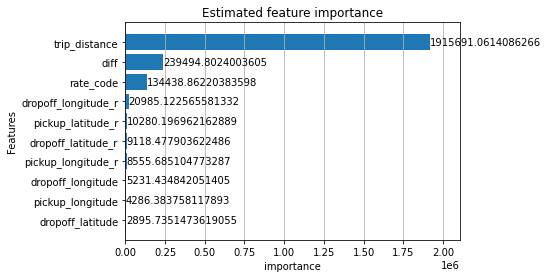

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgb.plot_importance(trained_model['booster'], height=0.8, max_num_features=10, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
ax.set_xlabel('importance')
plt.show()

# How Good is Our Model?

Now that we have a trained model, we need to test it with the 25% of records we held out.

Based on the filtering conditions applied to this dataset, many of the DataFrame partitions will wind up having 0 rows.

This is a problem for XGBoost which doesn't know what to do with 0 length arrays. We'll repartition the data. 

In [36]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

In [37]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']].persist()

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_test, Y_test])

# display test set size
len(X_test)

7905495

In [38]:
X_test.head()

,day,day_of_week,diff,dropoff_latitude,dropoff_latitude_r,dropoff_longitude,dropoff_longitude_r,h_distance,hour,is_weekend,month,passenger_count,pickup_latitude,pickup_latitude_r,pickup_longitude,pickup_longitude_r,rate_code,trip_distance,year
38,25,0.0,14,40.725559,40.719997,-73.996941,-74.000000,2.413343,0,1,1,1,40.727741,40.719997,-73.994812,-74.000000,1,0.02,2015
39,25,0.0,966,40.737865,40.730000,-74.006546,-74.010002,4.616995,0,1,1,1,40.726765,40.719997,-73.985939,-73.989998,1,1.73,2015
40,25,0.0,758,40.739056,40.730000,-74.008087,-74.010002,2.294490,0,1,1,1,40.743275,40.739998,-73.979988,-73.979996,1,2.25,2015
41,25,0.0,765,40.762470,40.759998,-73.978729,-73.979996,4.059519,0,1,1,1,40.721680,40.719997,-73.988968,-73.989998,1,3.53,2015
42,25,0.0,620,40.801991,40.799999,-73.957085,-73.959999,1.685555,0,1,1,1,40.782360,40.779999,-73.948685,-73.949997,1,2.01,2015


## Calculate Prediction

In [39]:
# generate predictions on the test set
'''feed X_test as a dask.dataframe'''
prediction = xgb.dask.predict(client, trained_model['booster'], X_test).persist()

wait(prediction)

prediction.head()

/home/ronaya/yes/envs/xgb/lib/python3.7/site-packages/distributed/worker.py:3349: UserWarning: Large object of size 1.42 MB detected in task graph: 
  [<function predict.<locals>.mapped_predict at 0x7f ... titions>, True]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


[12:40:57] WARNING: /workspace/include/xgboost/generic_parameters.h:36: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


0     2.632838
1    11.292425
2    10.532022
3    12.931385
4     9.458071
Name: prediction, dtype: float32

In [40]:
type(prediction), type(Y_test['fare_amount']), type(X_test)

(dask.dataframe.core.Series, dask_cudf.core.Series, dask_cudf.core.DataFrame)

In [46]:
pred = dask_cudf.from_dask_dataframe(prediction).reset_index()
true = Y_test['fare_amount'].reset_index()

In [47]:
type(true), type(pred)

(dask_cudf.core.DataFrame, dask_cudf.core.DataFrame)

In [48]:
pred.head()

,index,prediction
0,0,2.632838
1,1,11.292425
2,2,10.532022
3,3,12.931385
4,4,9.458071


In [49]:
true.head()

,index,fare_amount
0,38,2.5
1,39,11.0
2,40,10.5
3,41,12.5
4,42,9.5


In [50]:
# Calculate RMSE
squared_error = ((pred['prediction']-true['fare_amount'])**2)

# compute the actual RMSE over the full test set
math.sqrt(squared_error.mean().compute())

1.4100386269569485

## SAVE THE TRAINED MODEL

In [ ]:
# booster = trained_model['booster']  # booster is the trained model
# history = trained_model['history']  # A dictionary containing evaluation results
# # Save the model to file
# booster.save_model('xgboost-model')
# print('Training evaluation history:', history)

## VISUALIZATIONS with Pandas

In [212]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [209]:
X_test_cudf= X_test.compute()

X_test_cudf['fare_amount']= Y_test['fare_amount'].compute()
#X_test_cudf['prediction']= prediction

X_test_pd = X_test_cudf.to_pandas()

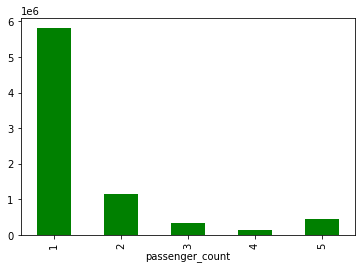

In [210]:
X_test_pd.groupby('passenger_count').size().plot.bar(color ='green')

0


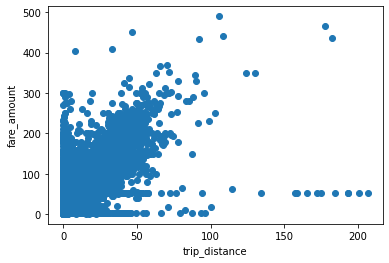

In [213]:
print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('trip_distance')     
ax.set_ylabel('fare_amount') 
ax.scatter(X_test_pd['trip_distance'], X_test_pd['fare_amount'])
plt.show()

10000


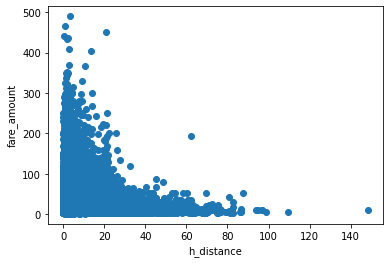

In [214]:
print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('h_distance')     
ax.set_ylabel('fare_amount')   
ax.scatter(X_test_pd['h_distance'], X_test_pd['fare_amount'])
plt.show()

10000


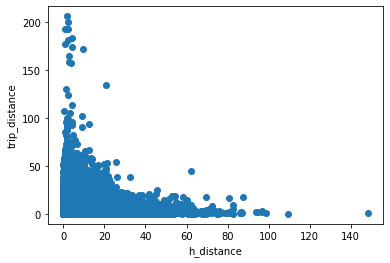

In [215]:
print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('h_distance')     
ax.set_ylabel('trip_distance')   
ax.scatter(X_test_pd['h_distance'], X_test_pd['trip_distance'])
plt.show()

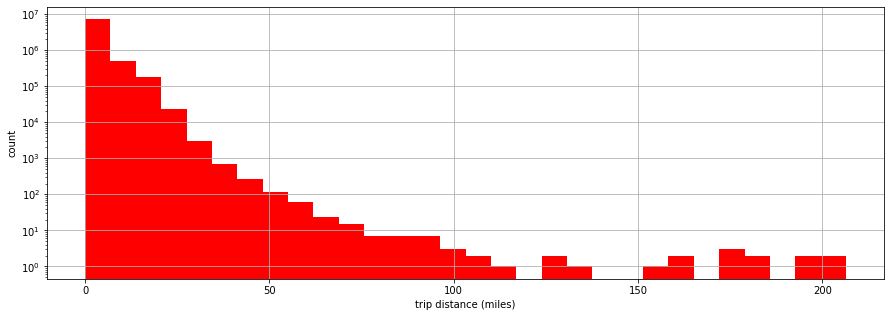

In [216]:
ax = X_test_pd['trip_distance'].hist(bins=30, figsize=(15,5), color='red')
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

/home/ronaya/yes/envs/xgb/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ronaya/yes/envs/xgb/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ronaya/yes/envs/xgb/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/ronaya/yes/envs/xgb/lib/py

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79401ab210>,
      dtype=object)

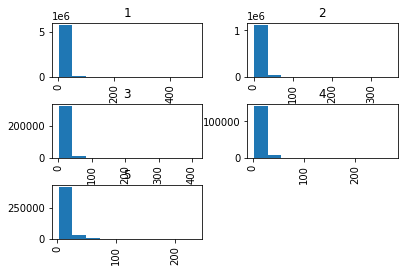

In [217]:
X_test_pd['fare_amount'].hist(by=X_test_pd['passenger_count'])

## VISUALS WITH CUXFILTER

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
import cuxfilter as cxf
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.charts import bokeh, datashader, panel_widgets
import datashader as ds
import datashader.transfer_functions as tf
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire

In [ ]:

# cvs = ds.Canvas(plot_width=500, plot_height=500, x_range=x_range, y_range=y_range)
# agg = cvs.points(X_test_cudf, 'pickup_longitude', 'pickup_latitude', ds.mean('prediction'))

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(X_test_cudf, 'pickup_longitude', 'pickup_latitude', ds.mean('fare_amount'))
tf.set_background(tf.shade(agg, cmap=['lightblue', 'darkblue']),"black")
# tf.set_background(tf.shade(agg, cmap=fire),"black")

In [219]:
X_test_cudf['day_of_week'].value_counts()

0.0    1198879
1.0    1121779
4.0    1081218
2.0    1078265
6.0    1061429
3.0    1027767
5.0     926402
Name: day_of_week, dtype: int32

In [ ]:

cux_df = cxf.DataFrame.from_dataframe(X_test_cudf)

cux_df.data['fare_amount'] = cux_df.data['fare_amount'].astype('float32')

label_map = {0.0: 'Sat', 1.0: 'Sun',    2.0: 'Mon',    3.0: 'Tues',    4.0: 'Wed',   5.0: 'Thu',    6.0: 'Fri'}
#red_blue_palette = [(49,130,189),(107,174,214), (123, 142, 216), (226,103,152), (255,0,104) , (50,50,50)]
red_yellow_palette = [(236,155,0), (236,202,0), (236,0,0),(236,36,0), (236,83,0)]

#declare charts
chart1 = cxf.charts.datashader.scatter_geo(x='pickup_longitude', y='pickup_latitude', aggregate_col='fare_amount', aggregate_fn='mean', color_palette=fire)
chart2 = cxf.charts.panel_widgets.multi_select('day_of_week')
chart3 = cxf.charts.bokeh.bar('day_of_week', x_label_map=label_map)
fare_vs_dist = cxf.charts.datashader.scatter(x='h_distance', y='fare_amount', x_range=(X_test_cudf['h_distance'].min(), X_test_cudf['h_distance'].max()), 
                                             y_range=(X_test_cudf['fare_amount'].min(), X_test_cudf['fare_amount'].max()))

#heatmap = cxf.charts.datashader.heatmap(x='pickup_longitude', y='pickup_latitude', aggregate_col='prediction', aggregate_fn='mean', color_palette=fire)

#declare dashboard

d = cux_df.dashboard([chart1, chart2, chart3, fare_vs_dist], layout=cxf.layouts.feature_and_double_base,theme = cxf.themes.light, 
                     title='Taxi Dataset', data_size_widget=True)

In [ ]:
d.show(notebook_url='10.110.46.158:8888')

In [ ]:
d.stop()